
# *Tutorial: Double-Phase Amplitude Coding (DPAC) for Computer-Generated Holography 🌊*
**Author:** Dong-Ha Shin | **Last Updated:** 2025-03-19

This tutorial explores the implementation and benefits of Double-Phase Amplitude Coding (DPAC) for Computer-Generated Holography (CGH). DPAC is a powerful technique that enables us to encode both amplitude and phase information into a phase-only hologram.

## 🔍 **Introduction**

Computer-Generated Holography (CGH) is a technique that calculates holographic patterns to manipulate light and create desired optical fields. One common challenge in CGH is that many Spatial Light Modulators (SLMs) can only modulate phase, but not amplitude. This creates a fundamental limitation when we want to reproduce a complex optical field that has both amplitude and phase components.


## 🚀 **Key Concepts**
- **Standard Phase-Only CGH**: Discards amplitude information, leading to reconstruction errors
- **DPAC**: Preserves amplitude information by encoding it in phase patterns
- **Encoding Types**: Different spatial patterns can be used (checkerboard, horizontal, vertical)
- **Improved Reconstruction**: DPAC typically provides higher quality reconstructions compared to standard phase-only approaches


## 💡 **How DPAC Works**

DPAC works by splitting a complex field into two phase components that, when properly interleaved, can reproduce both the amplitude and phase of the original field. This interleaving can follow different patterns such as checkerboard, horizontal, or vertical arrangements.


## 📊 **Implementation**

Let's implement DPAC and test it against a standard phase-only approach:

In [1]:
cd ../..

c:\Users\PC\Desktop\pado


In [2]:
import pado
from pado.light import Light
from pado.propagator import Propagator
from pado.math import calculate_psnr, cm, nm, um
import torch
import numpy as np
import matplotlib.pyplot as plt

class DPAC:
    """Double-Phase Amplitude Coding for CGH"""
    
    def __init__(self, encoding_type='checkerboard'):
        """Initialize DPAC encoder.
        
        Args:
            encoding_type (str): Encoding pattern type - 'checkerboard', 'horizontal', or 'vertical'
        """
        self.encoding_type = encoding_type
    
    def encode(self, field, three_pi=False, mean_adjust=True):
        """Convert a complex field to double phase coding.
        
        Args:
            field (torch.Tensor): Complex field tensor
            three_pi (bool): If True, outputs values in a 3pi range, instead of 2pi
            mean_adjust (bool): If True, centers the phases in the range of interest
            
        Returns:
            torch.Tensor: Phase-only encoded pattern
        """
        # Convert to complex if not already
        if not torch.is_complex(field):
            field = torch.complex(field, torch.zeros_like(field))
        
        # Get amplitude and phase
        amplitudes = field.abs()
        phases = field.angle()
        
        # Normalize amplitude
        if amplitudes.max() > 1:
            amplitudes = amplitudes / amplitudes.max()
        
        # Compute the two phase components
        phases_a = phases - torch.acos(amplitudes)
        phases_b = phases + torch.acos(amplitudes)
        
        # Initialize with phases_a
        phases_out = phases_a.clone()
        
        # Apply the encoding pattern
        if self.encoding_type == 'horizontal':
            # Horizontal row encoding
            phases_out[..., ::2, :] = phases_b[..., ::2, :]
        elif self.encoding_type == 'vertical':
            # Vertical row encoding
            phases_out[..., :, ::2] = phases_b[..., :, ::2]
        elif self.encoding_type == 'checkerboard':
            # Checkerboard encoding
            phases_out[..., ::2, 1::2] = phases_b[..., ::2, 1::2]
            phases_out[..., 1::2, ::2] = phases_b[..., 1::2, ::2]
        
        # Set the phase range
        if three_pi:
            max_phase = 3 * np.pi
        else:
            max_phase = 2 * np.pi
        
        # Adjust mean if requested
        if mean_adjust:
            phases_out -= phases_out.mean()
        
        # Wrap phases to the specified range
        return (phases_out + max_phase / 2) % max_phase - max_phase / 2


## 🧪 **Testing DPAC vs Standard Phase-Only CGH**

Now let's compare DPAC with a standard phase-only approach:

=== Comparing Standard CGH with DPAC ===
Using device: cuda

== Original Image ==


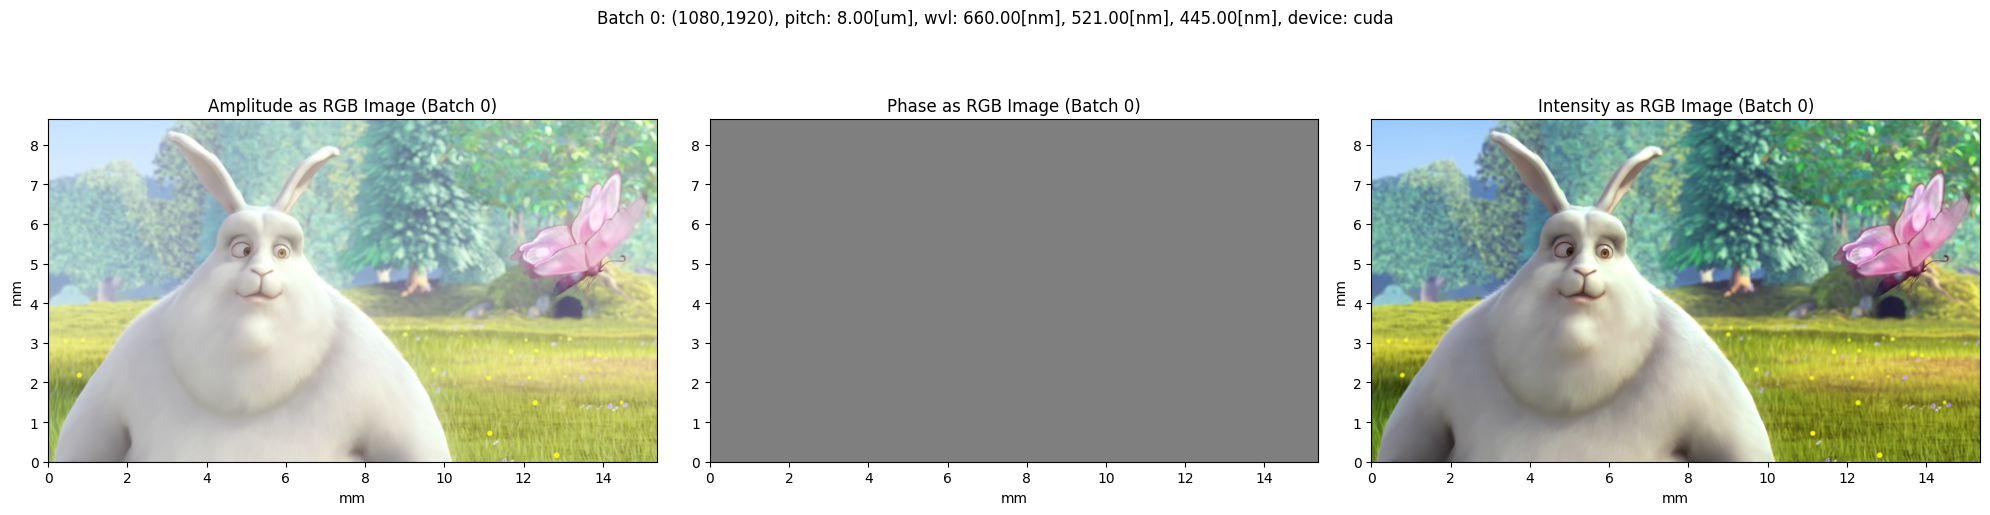


== Standard Phase-Only Pattern ==


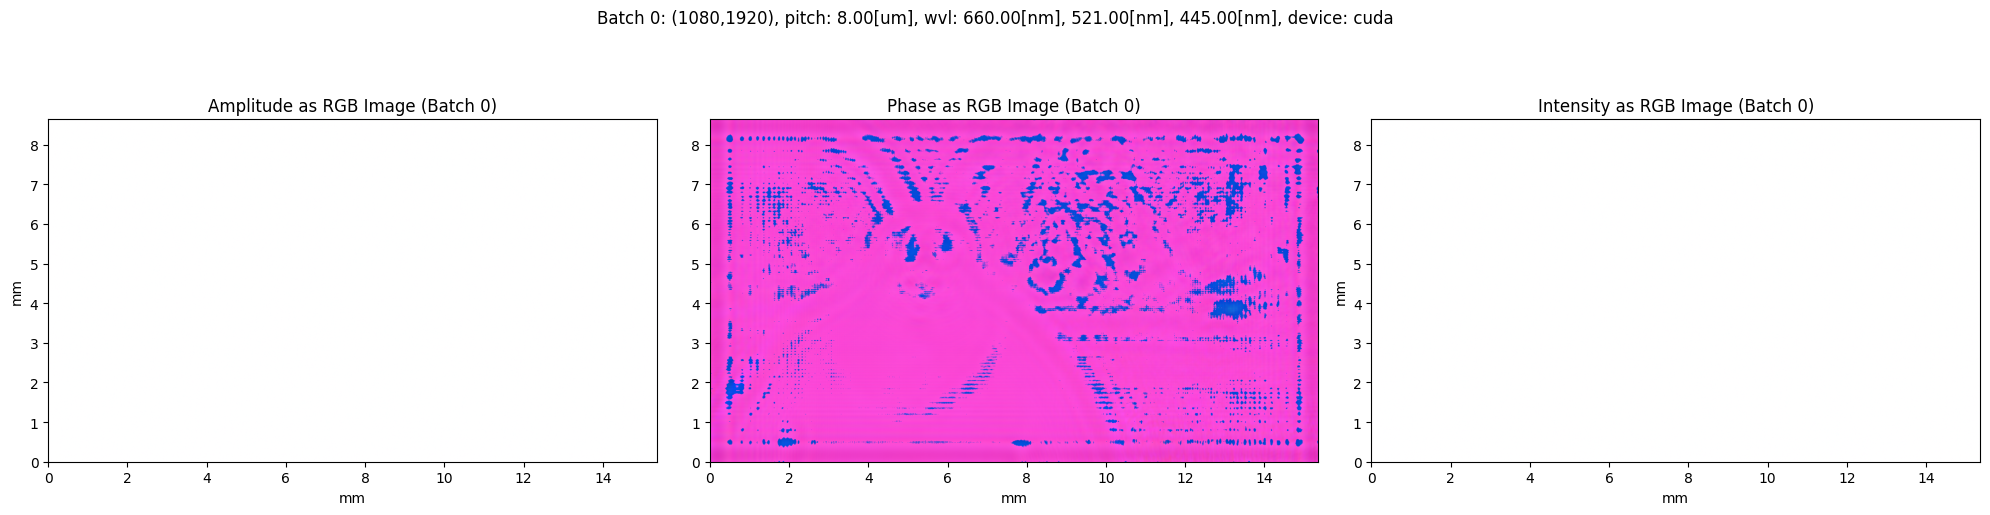


== DPAC Encoded Pattern ==


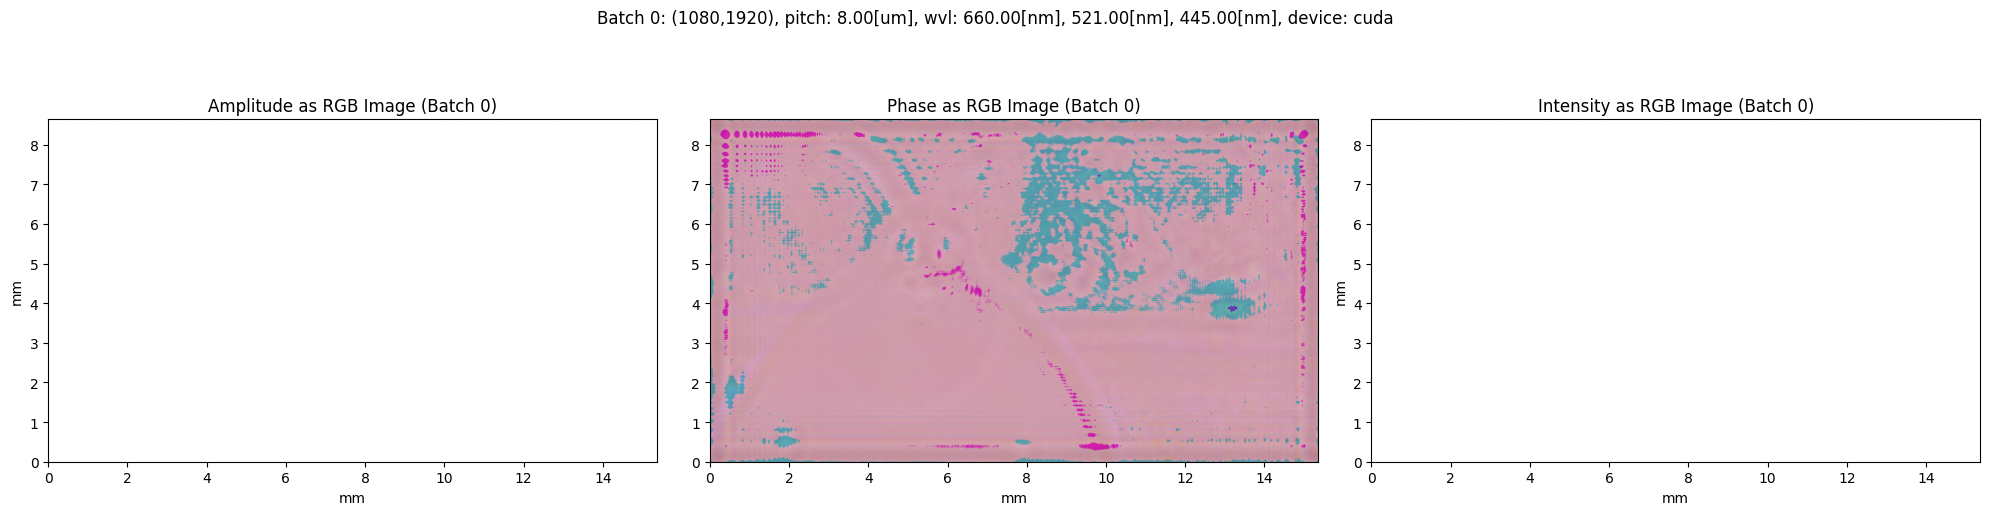


== Standard Phase-Only Reconstruction (PSNR: 6.05 dB) ==


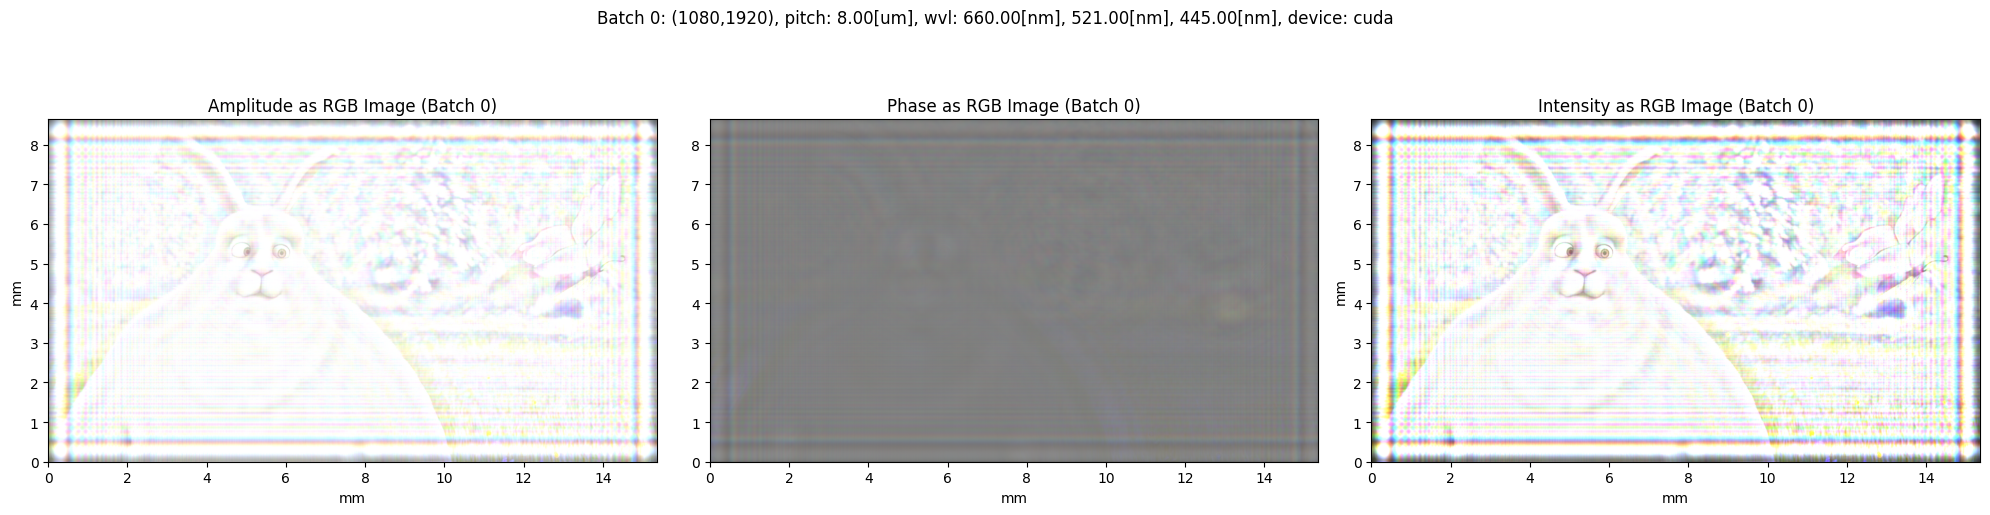


== DPAC Reconstruction (PSNR: 11.53 dB) ==


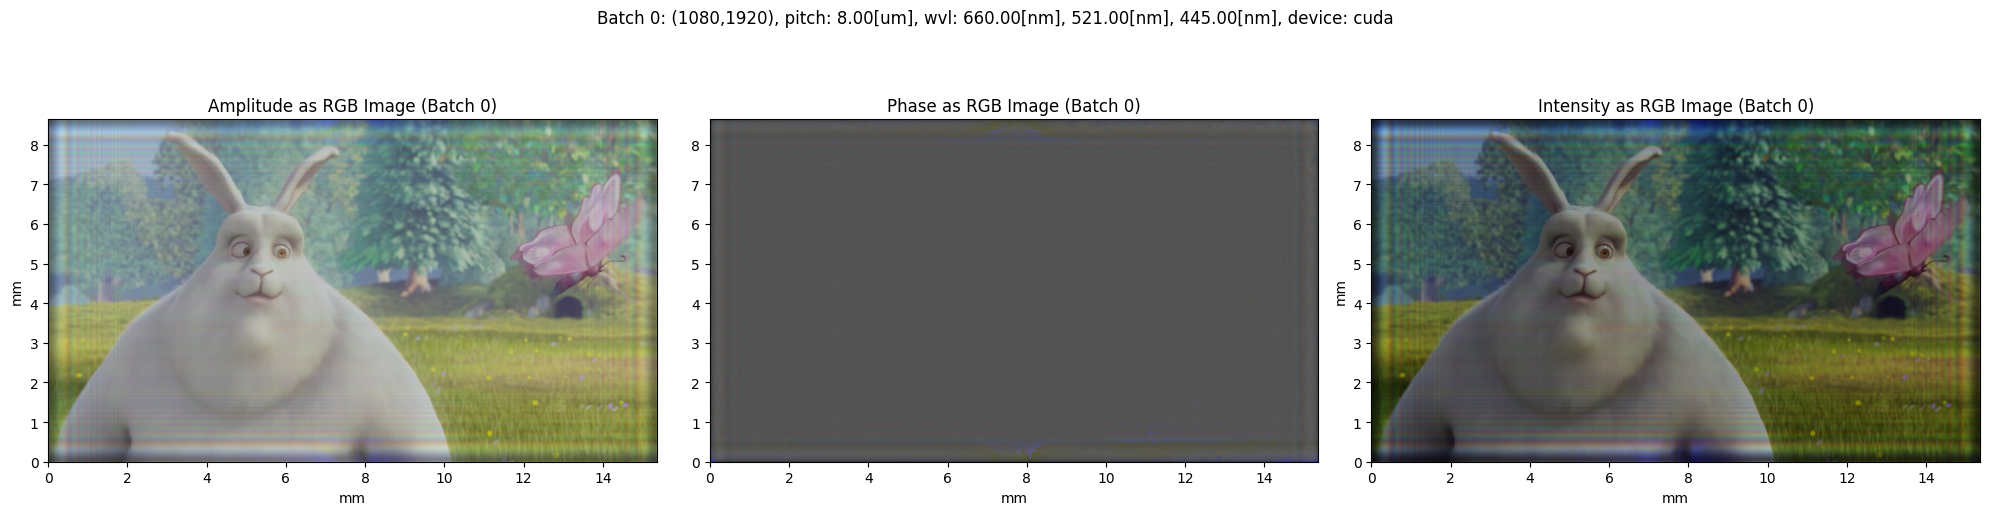


== Results Comparison ==
Standard Phase-Only CGH PSNR: 6.05 dB
DPAC CGH PSNR: 11.53 dB
PSNR Improvement: 5.48 dB


In [3]:
def compare_dpac_with_standard_cgh():
    """Compare DPAC with standard phase-only CGH using built-in visualization methods."""
    
    # Set up parameters
    R = 1080  # number of rows
    C = 1920  # number of columns
    pitch = 8.0*um  # physical size of each pixel in [m]
    wvl = [660*nm, 521*nm, 445*nm]  # wavelength of the light in [m]
    dim = (1, 3, R, C)  # dimension of the light [batch, channel, row, column]
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    print(f"Using device: {device}")
    
    # Create propagator
    prop = Propagator('ASM')
    
    # Distance for reconstruction
    dist = 30 * cm
    
    # Create DPAC encoder
    dpac_encoder = DPAC(encoding_type='checkerboard')
    
    # Create input field with image
    input_light = Light(dim, pitch, wvl, device=device)
    input_light.load_image("example/asset/bunny.PNG", random_phase=False)
    
    print("\n== Original Image ==")
    input_light.visualize_image()
    
    # Propagate to SLM plane
    slm_plane = prop.forward(input_light, dist)
    
    # METHOD 1: Standard phase-only CGH (discard amplitude)
    std_phase_only = slm_plane.clone()
    std_phase_only.set_amplitude(torch.ones_like(std_phase_only.get_amplitude()))
    
    print("\n== Standard Phase-Only Pattern ==")
    std_phase_only.visualize_image()
    
    # METHOD 2: DPAC encoding
    slm_field = slm_plane.get_field()
    dpac_phase = dpac_encoder.encode(slm_field)
    dpac_light = slm_plane.clone()
    dpac_light.set_phase(dpac_phase)
    dpac_light.set_amplitude(torch.ones_like(dpac_phase))
    
    print("\n== DPAC Encoded Pattern ==")
    dpac_light.visualize_image()
    
    # Reconstruct both methods
    recon_std = prop.forward(std_phase_only, -dist)
    recon_dpac = prop.forward(dpac_light, -dist)
    
    # Calculate PSNR for both methods
    psnr_std = calculate_psnr(input_light.get_intensity(), recon_std.get_intensity())
    psnr_dpac = calculate_psnr(input_light.get_intensity(), recon_dpac.get_intensity())
    
    print(f"\n== Standard Phase-Only Reconstruction (PSNR: {psnr_std:.2f} dB) ==")
    recon_std.visualize_image()
    
    print(f"\n== DPAC Reconstruction (PSNR: {psnr_dpac:.2f} dB) ==")
    recon_dpac.visualize_image()
    
    print(f"\n== Results Comparison ==")
    print(f"Standard Phase-Only CGH PSNR: {psnr_std:.2f} dB")
    print(f"DPAC CGH PSNR: {psnr_dpac:.2f} dB")
    print(f"PSNR Improvement: {psnr_dpac - psnr_std:.2f} dB")
    
    return input_light, std_phase_only, dpac_light, recon_std, recon_dpac


# Compare standard method with DPAC
print("=== Comparing Standard CGH with DPAC ===")
input_light, std_phase_only, dpac_light, recon_std, recon_dpac = compare_dpac_with_standard_cgh()



## 🔬 **Exploring Different Encoding Patterns**

DPAC offers different encoding patterns. Let's examine how they affect reconstruction quality



=== Comparing Different DPAC Encoding Patterns ===

== Original Image ==


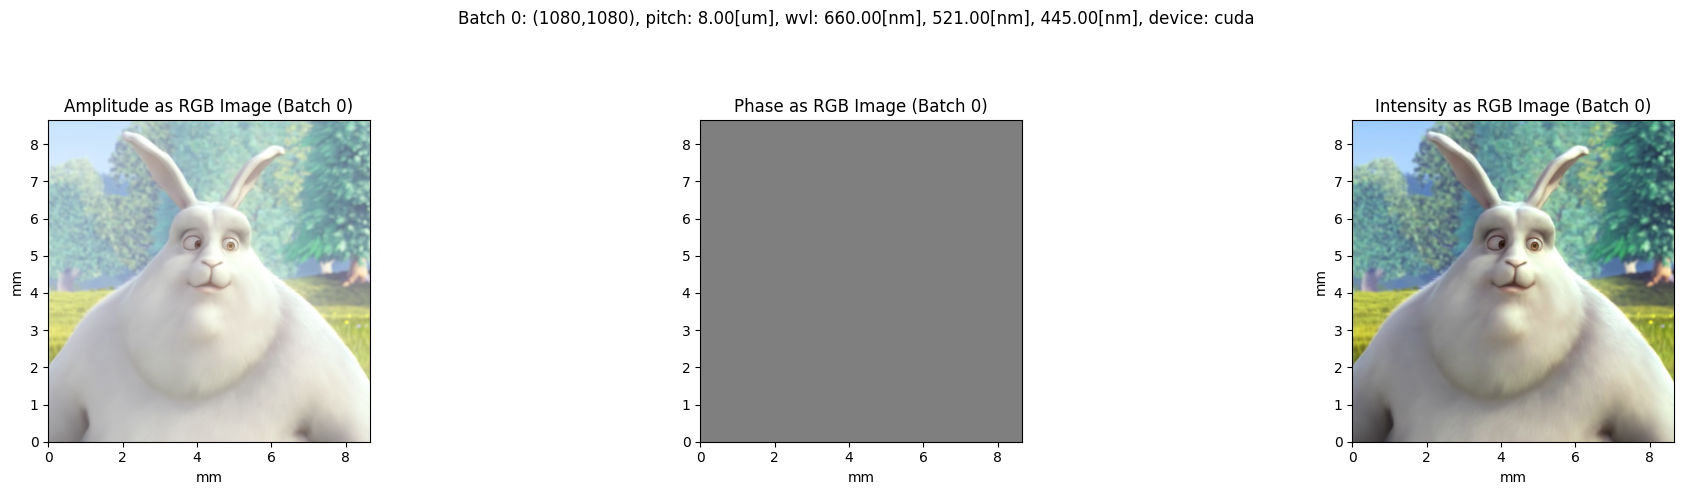


== Checkerboard Encoding Pattern ==


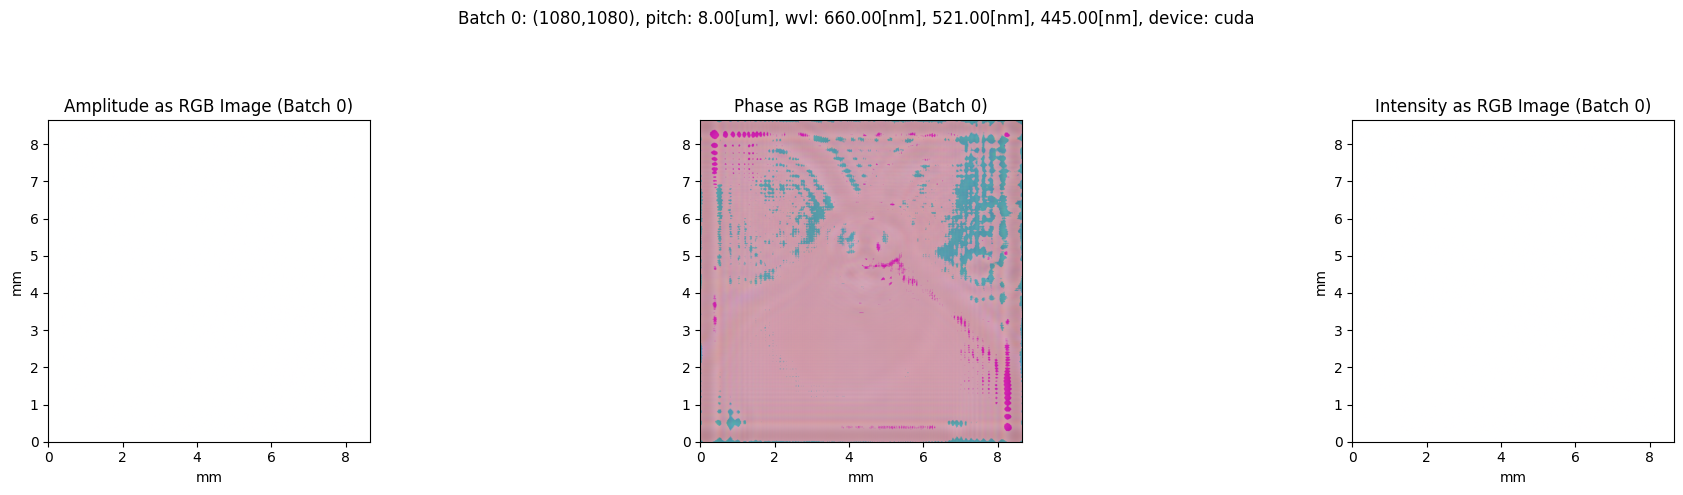


== Checkerboard Encoding Reconstruction Result (PSNR: 10.94 dB) ==


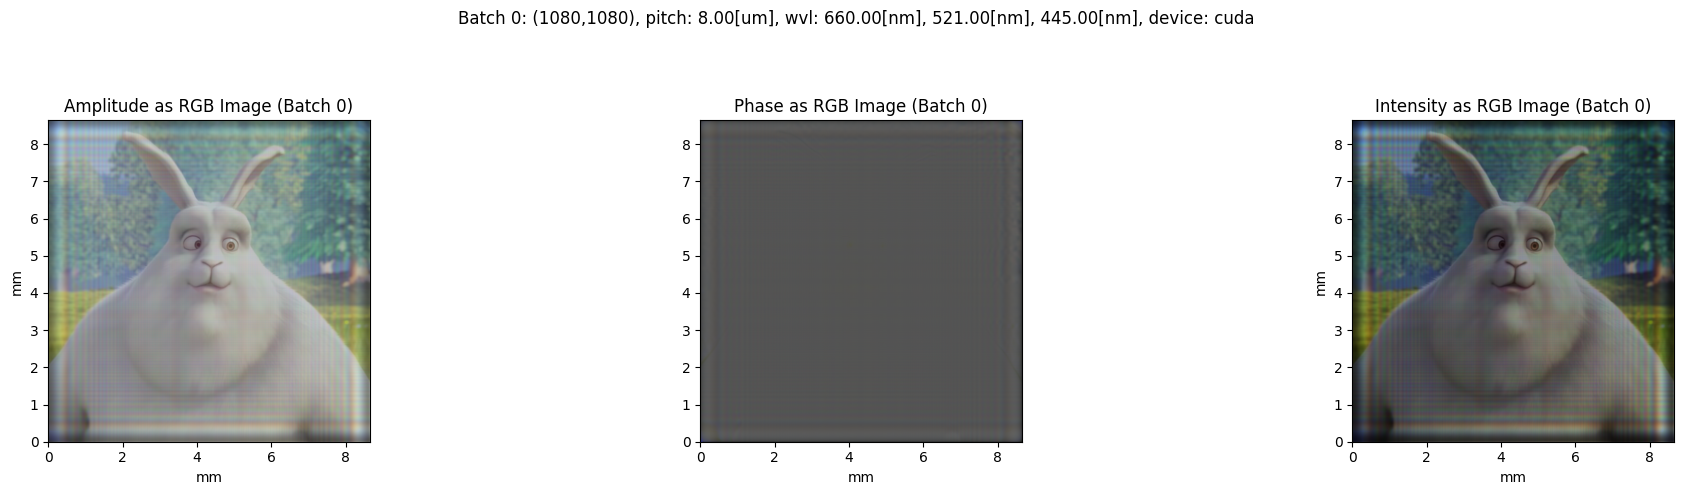


== Horizontal Encoding Pattern ==


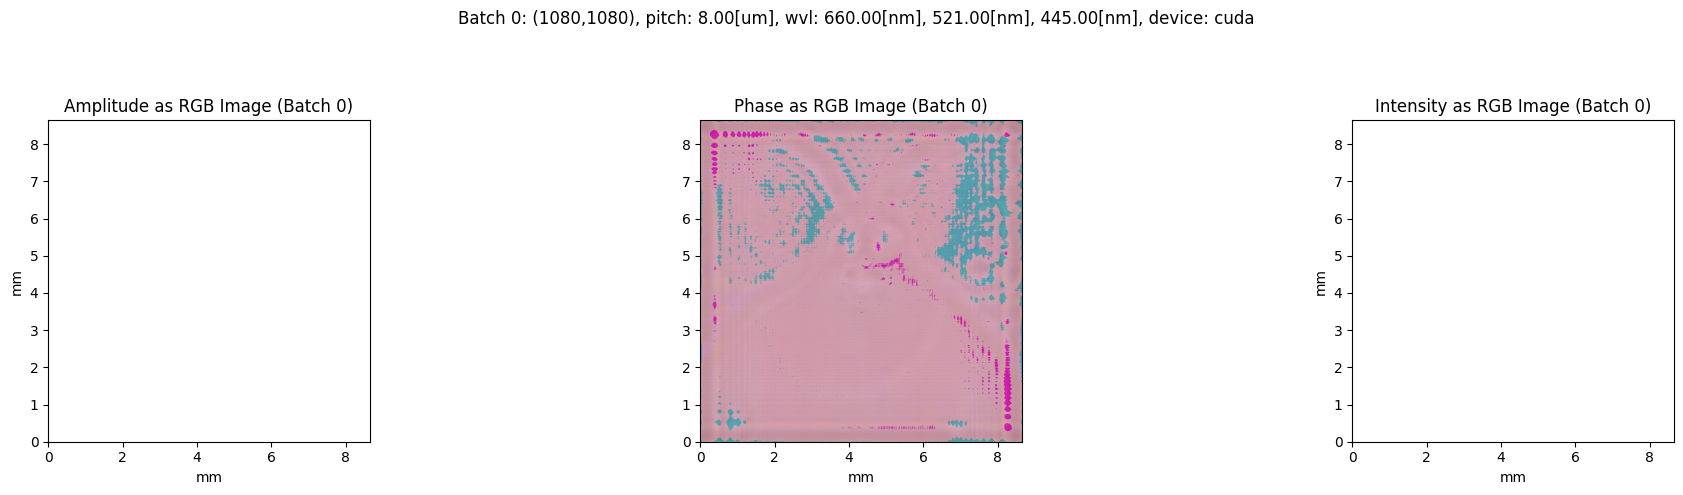


== Horizontal Encoding Reconstruction Result (PSNR: 10.83 dB) ==


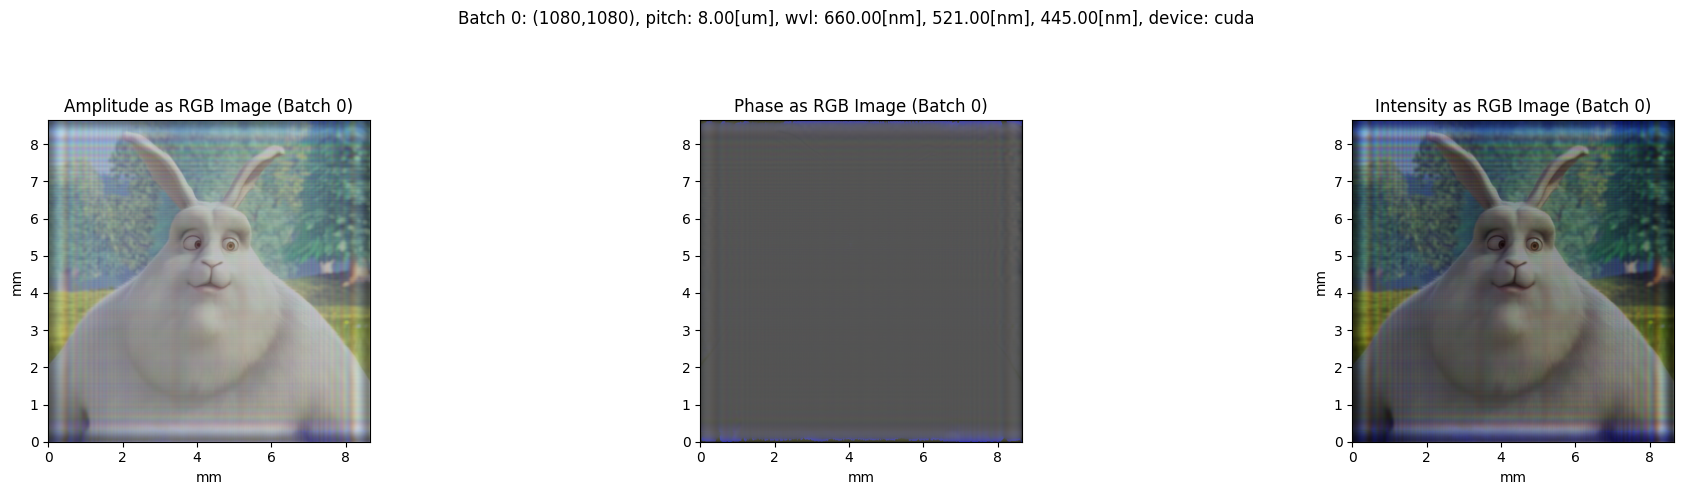


== Vertical Encoding Pattern ==


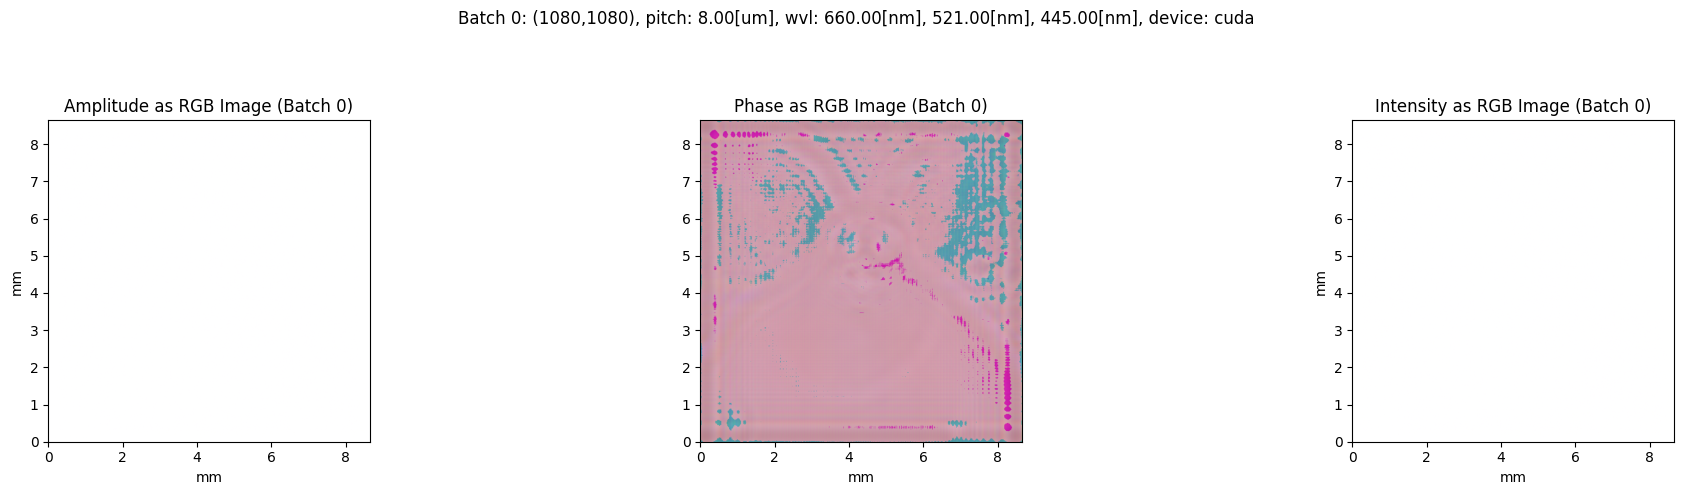


== Vertical Encoding Reconstruction Result (PSNR: 10.82 dB) ==


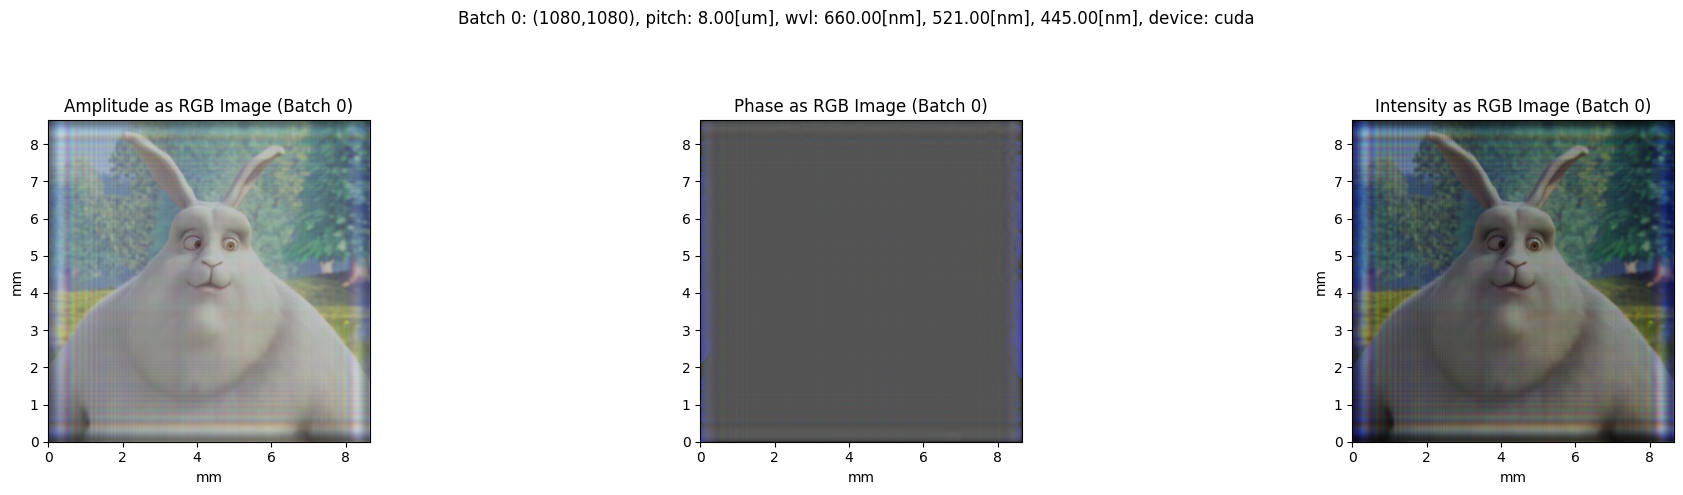


== PSNR Comparison Results ==
Checkerboard Encoding PSNR: 10.94 dB
Horizontal Encoding PSNR: 10.83 dB
Vertical Encoding PSNR: 10.82 dB


In [4]:
def explore_encoding_patterns():
    """Test different DPAC encoding patterns using built-in visualization methods."""
    
    # Set up parameters
    R = 1080  # number of rows
    C = 1080  # number of columns
    pitch = 8.0*um  # physical size of each pixel in [m]
    wvl = [660*nm, 521*nm, 445*nm]  # wavelength of the light in [m]
    dim = (1, 3, R, C)  # dimension of the light [batch, channel, row, column]
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Create propagator
    prop = Propagator('ASM')
    
    # Distance for reconstruction
    dist = 30 * cm
    
    # Create input field with image
    input_light = Light(dim, pitch, wvl, device=device)
    input_light.load_image("example/asset/bunny_1_1.PNG", random_phase=False)
    
    print("\n== Original Image ==")
    input_light.visualize_image()
    
    # Propagate to SLM plane
    slm_plane = prop.forward(input_light, dist)
    slm_field = slm_plane.get_field()
    
    # Create encoders with different patterns
    patterns = ['checkerboard', 'horizontal', 'vertical']
    encoded_lights = []
    recon_lights = []
    psnr_values = []
    
    for pattern in patterns:
        # Create encoder with current pattern
        encoder = DPAC(encoding_type=pattern)
        
        # Encode the field
        dpac_phase = encoder.encode(slm_field)
        
        # Create a light object with the encoded phase
        dpac_light = slm_plane.clone()
        dpac_light.set_phase(dpac_phase)
        dpac_light.set_amplitude(torch.ones_like(dpac_phase))
        
        # Reconstruct the image
        recon_light = prop.forward(dpac_light, -dist)
        
        # Calculate PSNR
        psnr = calculate_psnr(input_light.get_intensity(), recon_light.get_intensity())
        
        # Store for comparison
        encoded_lights.append(dpac_light)
        recon_lights.append(recon_light)
        psnr_values.append(psnr)
        
        print(f"\n== {pattern.capitalize()} Encoding Pattern ==")
        dpac_light.visualize_image()
        
        print(f"\n== {pattern.capitalize()} Encoding Reconstruction Result (PSNR: {psnr:.2f} dB) ==")
        recon_light.visualize_image()
    
    # Print summary of results
    print("\n== PSNR Comparison Results ==")
    for pattern, psnr in zip(patterns, psnr_values):
        print(f"{pattern.capitalize()} Encoding PSNR: {psnr:.2f} dB")
    
    return patterns, encoded_lights, recon_lights, psnr_values

print("\n\n=== Comparing Different DPAC Encoding Patterns ===")
patterns, encoded_lights, recon_lights, psnr_values = explore_encoding_patterns()


## 🧮 **Understanding the Math Behind DPAC**


DPAC works by breaking down a complex field into two phase components. For a complex field with amplitude $A$ and phase $\phi$, we can represent it as:


$E = A e^{j\phi}$


DPAC splits this into two phase-only fields:


$E_1 = e^{j(\phi - \arccos(A))}$


$E_2 = e^{j(\phi + \arccos(A))}$



By alternating between these two phase patterns in a spatial pattern (like a checkerboard), we can encode both amplitude and phase information into a single phase-only field.
When this field propagates, the two components interfere to reconstruct the original amplitude and phase distribution with higher fidelity than simply discarding the amplitude information.